In [ ]:
library(readr)
library(dplyr)
library(tidyr)
library(stringr)
library(doMC)
library(lubridate)
library(ggplot2)
library(lfe)
library(ggsci)
library(doMC)
registerDoMC(24)

In [ ]:
fp  <- '/pool001/mfzhao/'
df  <- read_rds(str_c(fp, 'PROCESSED_DATA/panel_pre_xgr.RDS'))
pp  <- read_csv(str_c(fp, 'PROCESSED_DATA/policyPeriods.csv'))
WM  <- read_rds(str_c(fp, 'PROCESSED_DATA/stateWM.RDS'))

In [14]:
df %>%
    mutate(as_newcases  = asinh(newcases),
           as_newdeaths = asinh(newdeaths),
           as_stnewcases  = asinh(stnewcases),
           as_stnewdeaths = asinh(stnewdeaths),
           ct_unemp_rate = as.numeric(ct_unemp_rate),
           st_unemp_rate = as.numeric(st_unemp_rate)) %>%
    select(key,
           date, 
           cluster,
           n,
           log_mcbgv,
           log_pnchd,
           log_pgt1hafh, 
           log_ppthlt75,
           log_pgt2kmt,
           matches('unemp'),
           matches('^log_stalter_'), 
           matches('^[pt][rm][ca][px][01][0-9]$'),
           matches('^p[123]...$'),
           matches('stalter_p[123]...$'),
           matches('stalter[NF]'),
           matches('stalter_[pt][rm][ca][px][01][0-9]$'),
           matches('as_(st)?new')) -> df

In [8]:
weightedAlters <- function(df, wm, ...) {
    df %>% 
        select(date, key, ...) %>%
        spread(key = key, value = ...) %>%
        ungroup() %>%
        select(-date) %>%
        as.matrix() -> txn_data
    
    df %>%
        ungroup() %>%
        select(date) %>%
        distinct() %>%
        arrange(date) -> dates
    
    outMatrix <- tcrossprod(txn_data, wm)
    colnames(outMatrix) <- colnames(txn_data)
    
    data.frame(dates, outMatrix) %>%
        gather(key = 'key', value = 'value', -date) %>%
        arrange(date, key) %>%
        select(-date, -key) -> out_df
    return(out_df$value)
}

In [9]:
pp %>%
    mutate(cluster = str_sub(key, 1, 2)) %>%
    select(-key) %>%
    distinct() %>%
    rename(p1date = p1sdp, 
           p2date = p2shp,
           p3date = p3rop) -> statePolicy

In [20]:
get_coefs <- function(df, dv, vars, ivmod = F, ...) {
    lhs <- str_c(dv, ' ~ ')
    rhs <- str_c(vars, '| key + date | ')

    if(ivmod == T) {
        alter_weather <- str_c(cns[str_detect(cns, '^stalter_[pt][rm][ca][px][01][0-9]$')], collapse = ' + ')
        iv <- ifelse(str_detect(dv, 'log'), str_replace(dv, 'log', 'log_stalter'), str_c('alter_', dv))
        ivf <- str_c('(', iv, ' ~ ', alter_weather, ') | cluster')
        rhs <- str_c(rhs, ivf)
    } else {
        rhs <- str_c(rhs, '0 | cluster')
    }
    form  <- as.formula(str_c(lhs, rhs))
    model <- felm(form, df, weights = df$n, ...)
    
    as.data.frame(summary(model)$coef) %>%
        mutate(var   = rownames(.),
               dv    = dv,
               model = ifelse(vars == f1, 'base', 
                              ifelse(vars == f2, 'ap', 'apnf')),
               model = ifelse(ivmod, str_c(model, ' + iv'), model)) %>%
        filter(!str_detect(var, '[pPtT][rRmM][cCaA][pPxX]')) %>%
        filter(!str_detect(var, 'new')) %>%
        filter(!str_detect(var, 'as_')) %>%
        filter(!str_detect(var, 'unemp')) %>%
        select(7, 6, 5, 1, 2, 3, 4) -> out
    
    colnames(out) <- c('model', 'dv', 'var', 'estimate', 'se', 't', 'p-val')
    return(out)
}

In [11]:
ctrls <- '+ prcp01 + prcp02 + prcp03 + prcp04 + prcp05 + prcp06 + prcp07 + prcp08 + prcp09 + prcp10 + 
            tmax02 + tmax03 + tmax04 + tmax05 + tmax06 + tmax07 + tmax08 + tmax09 + tmax10 + 
            as_newcases + as_newdeaths + as_stnewcases + as_stnewdeaths + ct_unemp_rate + st_unemp_rate '
f1    <- str_c(' p1sdp + p2shp + p3rop ', ctrls)  
f2    <- str_c(' p1sdp + p2shp + p3rop + stalter_p1sdp + stalter_p2shp + stalter_p3rop ', ctrls)

In [21]:
fri <- function(df, iter) {
    df %>%
        select(-matches('p1sdp'),
               -matches('p2shp'),
               -matches('p3rop')) %>%
        left_join(statePolicy %>%
                  mutate(cluster = sample(cluster, n(), replace = F))) %>%
        mutate(p1sdp = as.numeric(date - p1date >= 0),
               p2shp = ifelse(is.na(p2date), 0, as.numeric(date - p2date >= 0)),
               p3rop = as.numeric(date - p3date >= 0)) %>%
        ungroup() %>%
        mutate(stalter_p1sdp =  weightedAlters(., WM, p1sdp),
               stalter_p2shp =  weightedAlters(., WM, p2shp),
               stalter_p3rop =  weightedAlters(., WM, p3rop)) -> temp
    
    ldvs <- c('log_mcbgv', 'log_pgt2kmt', 'log_pgt1hafh', 'log_pnchd')
    
    foreach(dv = ldvs, .combine = rbind) %:% 
        foreach(f = c(f1, f2), .combine = rbind) %do%
        get_coefs(temp, dv, f) %>%
        select(-se, -t) %>%
        mutate(iter = iter) -> coefs
    
    return(coefs)
}

In [23]:
foreach(i = 1:500, .combine = rbind) %dopar% fri(df, i) -> fri_results

In [22]:
ldvs <- c('log_mcbgv', 'log_pgt2kmt', 'log_pgt1hafh', 'log_pnchd')

foreach(dv = ldvs, .combine = rbind) %:% 
    foreach(f = c(f1, f2), .combine = rbind) %dopar%
    get_coefs(df, dv, f) -> coefs

Warning message:
“Ignoring unknown parameters: inherit.aes”


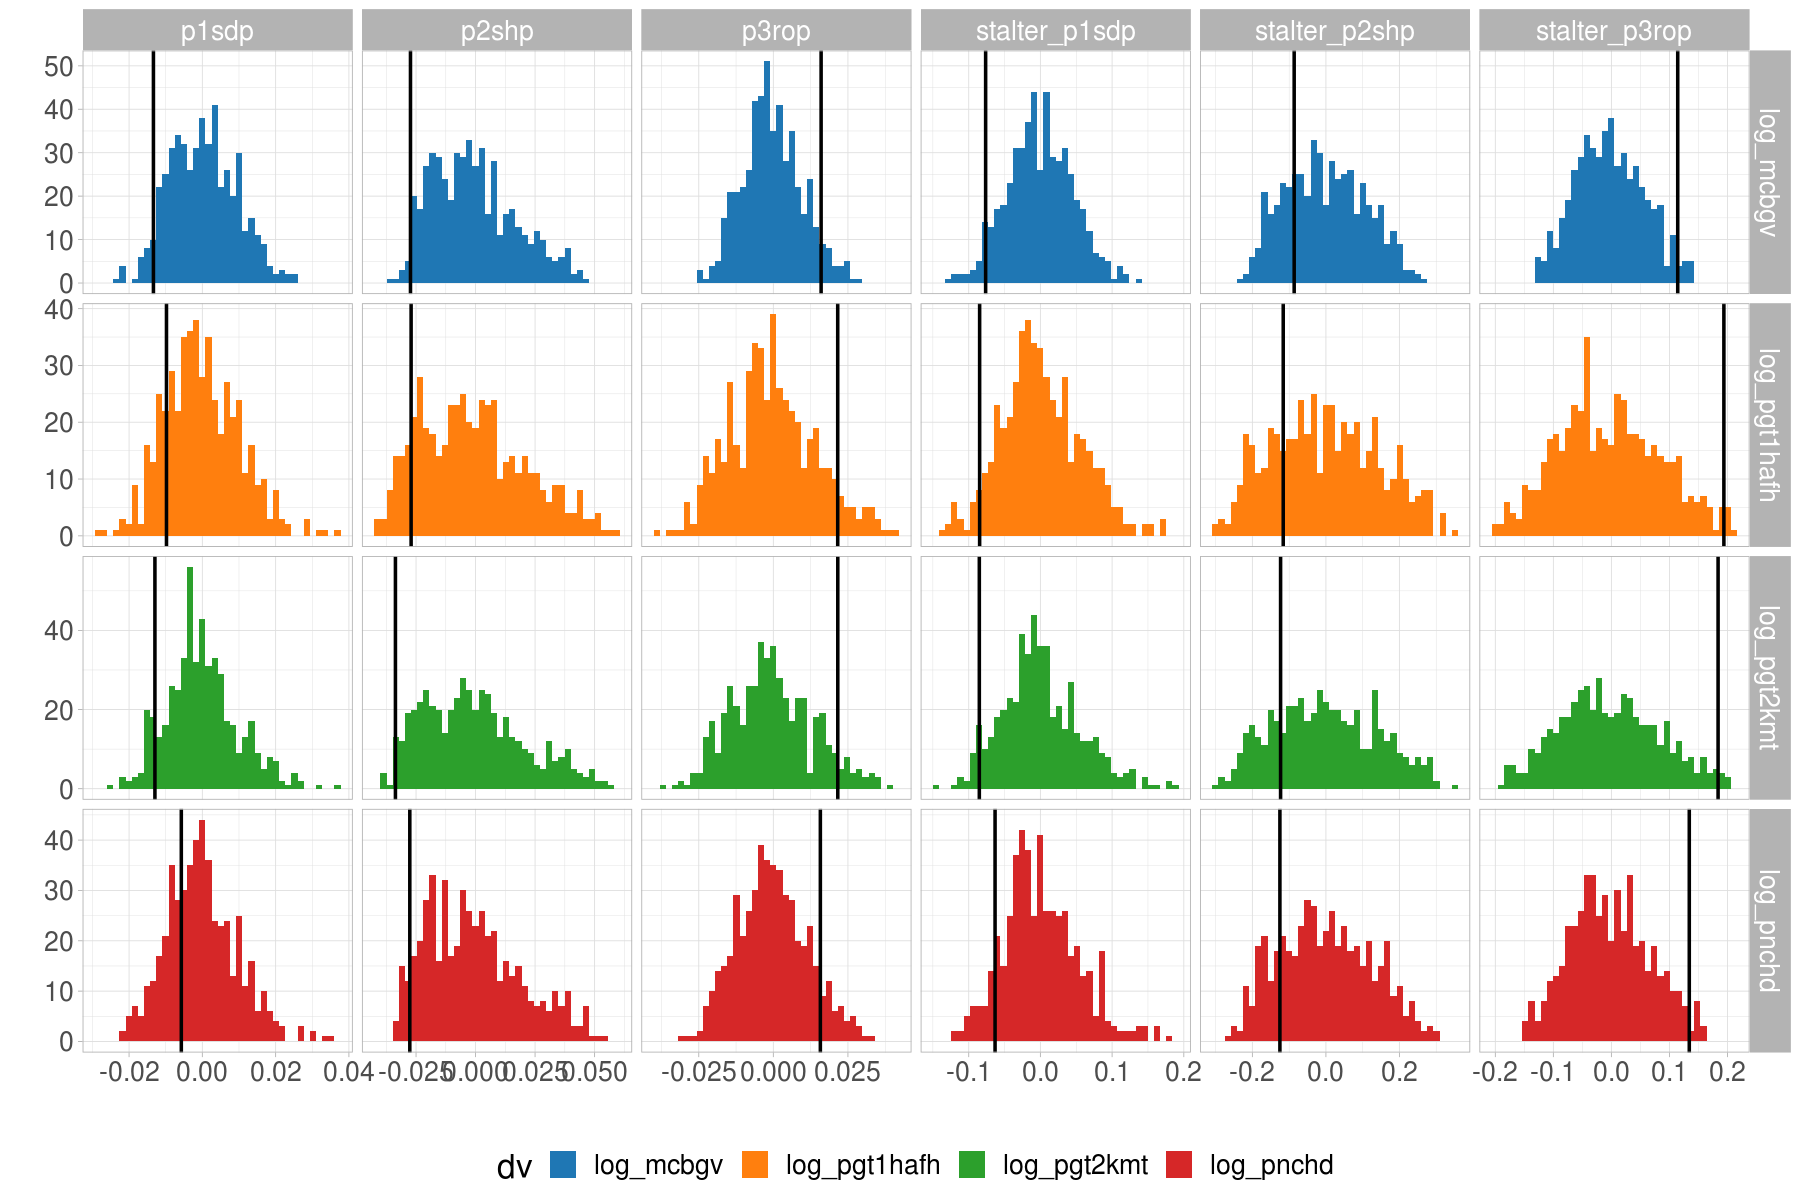

In [29]:
coefs %>%
    filter(model == 'ap') -> base

options(repr.plot.width=15, repr.plot.height=10)
fri_results %>%
    filter(model == 'ap') %>%
    mutate(estimate = ifelse(var != 'p1sdp', estimate, estimate)) %>%
    ggplot(aes(x = estimate, fill = dv)) + 
    geom_histogram(bins = 40) + 
    geom_vline(aes(xintercept = estimate), size = 1, data = base, color = 'black', inherit.aes = F) +
    facet_grid(dv ~ var, scales = 'free') +
    xlab('') + 
    ylab('') +
    scale_fill_d3() +
    theme_light() + 
    theme(text = element_text(size = 20),
          legend.position = 'bottom') -> p
p
ggsave('/home/mfzhao/SI_plots/rc3a_fri_main.pdf', p, device = 'pdf', width = 6.5, height = 6.5, scale = 2)

In [30]:
fri_results %>%
    filter(model == 'ap') %>%
    mutate(estimate = ifelse(var != 'p1sdp', estimate, estimate)) %>%
    left_join(base %>% select(model, dv, var, base = estimate)) %>%
    group_by(model, dv, var) %>%
    summarize(pv = sum(estimate > base)/500) %>%
    mutate(pv = ifelse(pv > 0.5, (1 - pv), pv)) %>%
    spread(key = dv, value = pv) %>%
    ungroup() %>%
    select(var, log_mcbgv, log_pgt2kmt, log_pgt1hafh, log_pnchd)

Joining, by = c("model", "dv", "var")



var,log_mcbgv,log_pgt2kmt,log_pgt1hafh,log_pnchd
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
p1sdp,0.050,0.094,0.176,0.294
p2shp,0.020,0.016,0.118,0.058
p3rop,0.054,0.066,0.074,0.094
stalter_p1sdp,0.040,0.052,0.050,0.094
stalter_p2shp,0.242,0.224,0.246,0.188
stalter_p3rop,0.026,0.014,0.016,0.026
